Introduce the project here

# Task 0 #

In [15]:
import qiskit, qiskit_ibm_runtime, qiskit_aer
print(qiskit.__version__, qiskit_ibm_runtime.__version__, qiskit_aer.__version__)

2.1.2 0.41.1 0.17.1


# Task 1 #

In [16]:
from dotenv import load_dotenv
import os

load_dotenv()  # take variables from .env

api_key = os.getenv("API_KEY")
crn = os.getenv("INSTANCE_CRN")

In [17]:
# imports
from qiskit_ibm_runtime import QiskitRuntimeService
# >>> Edit these two lines:
TOKEN = api_key   # REQUIRED
INSTANCE = crn # OPTIONAL: e.g., "crn:v1:bluemix:public:quantum-computing:us-east:...:..."

# Safety check to avoid empty tokens
if not TOKEN or TOKEN.strip() in {"", "<PASTE-YOUR-IBM-QUANTUM-API-KEY-HERE>"}:
    raise ValueError("Please paste your IBM Quantum API key into TOKEN (between quotes) and run again.")

# Create the service directly (no saved account needed)
service = QiskitRuntimeService(
    channel="ibm_quantum_platform",
    token=TOKEN.strip(),
    instance=(INSTANCE.strip() if isinstance(INSTANCE, str) and INSTANCE.strip() else None),
)

# Quick sanity check
backends = service.backends(operational=True, simulator=False)
print("OK. Found", len(backends), "real backends. Example:", [b.name for b in backends[:3]])

OK. Found 2 real backends. Example: ['ibm_brisbane', 'ibm_torino']


In [18]:
# save the CRN and API for future use

QiskitRuntimeService.save_account(
    channel="ibm_quantum_platform",
    token=TOKEN.strip(),
    instance=(INSTANCE.strip() if isinstance(INSTANCE, str) and INSTANCE.strip() else None),
    set_as_default=True,
    overwrite=True,
)
print("Saved default account for this runtime.")

Saved default account for this runtime.


In [53]:
cands = service.backends(simulator=False, operational=True, min_num_qubits=6)
for b in cands: print(b.name, b.num_qubits)

A = service.least_busy(simulator=False, operational=True, min_num_qubits=6)
B = next(b for b in cands if b.name != A.name)
A, B
print (B)

ibm_torino 133
ibm_brisbane 127
<IBMBackend('ibm_brisbane')>


In [20]:
cfgA = A.configuration(); cfgB = B.configuration()
print("A basis_gates:", cfgA.basis_gates)
print("B basis_gates:", cfgB.basis_gates)
cmapA = A.coupling_map; cmapB = B.coupling_map

A basis_gates: ['cz', 'id', 'rz', 'sx', 'x']
B basis_gates: ['ecr', 'id', 'rz', 'sx', 'x']


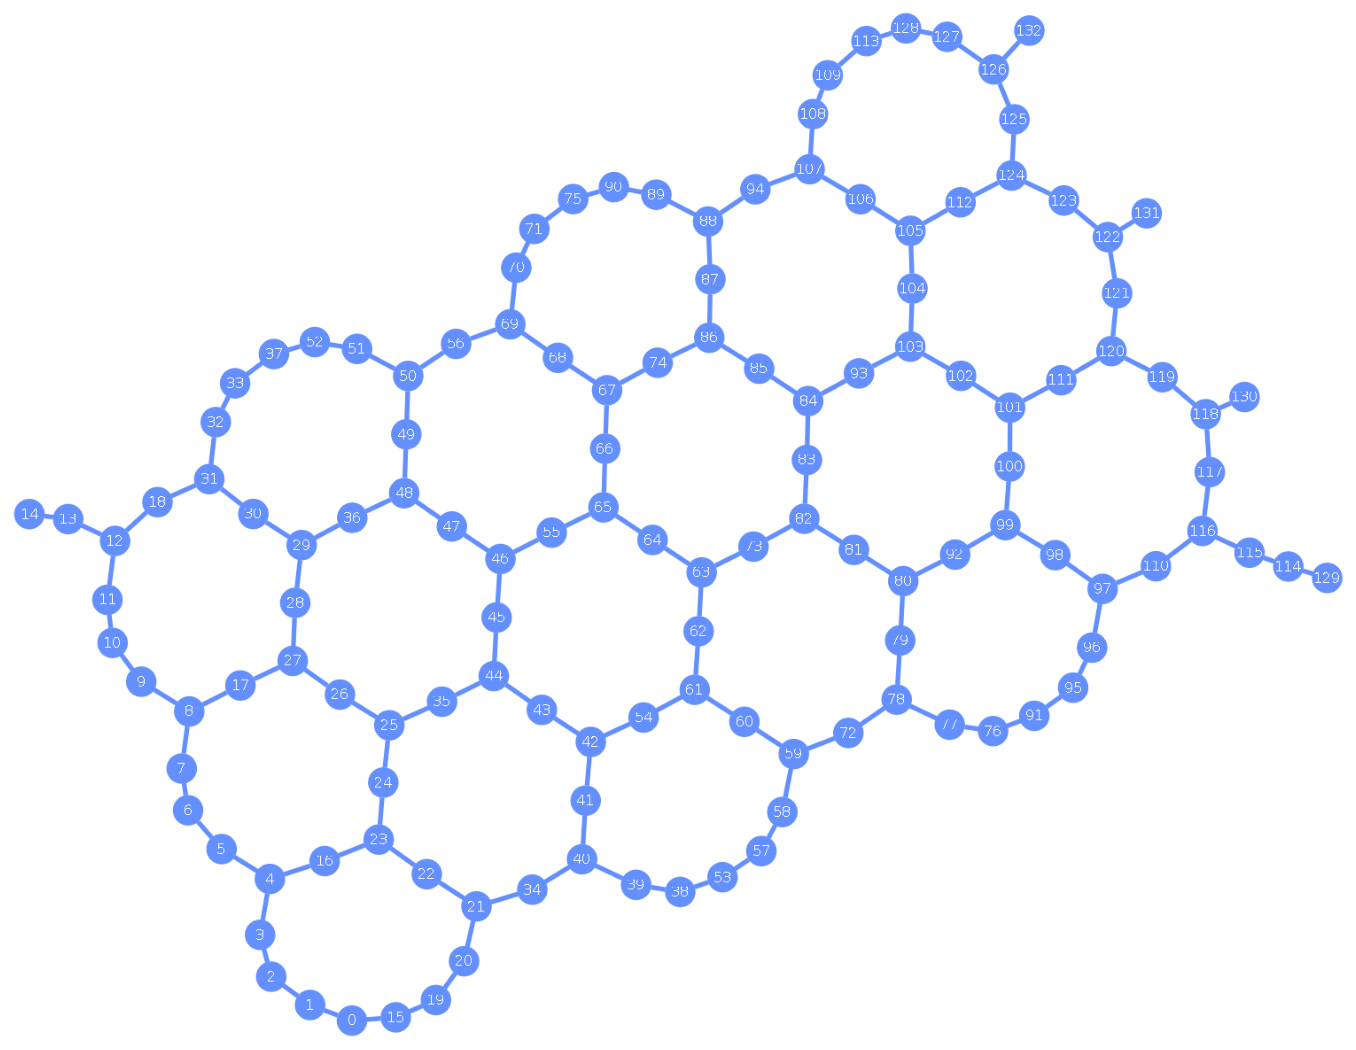

In [21]:
from qiskit.visualization import plot_coupling_map
plot_coupling_map(A.num_qubits, None, cmapA.get_edges())

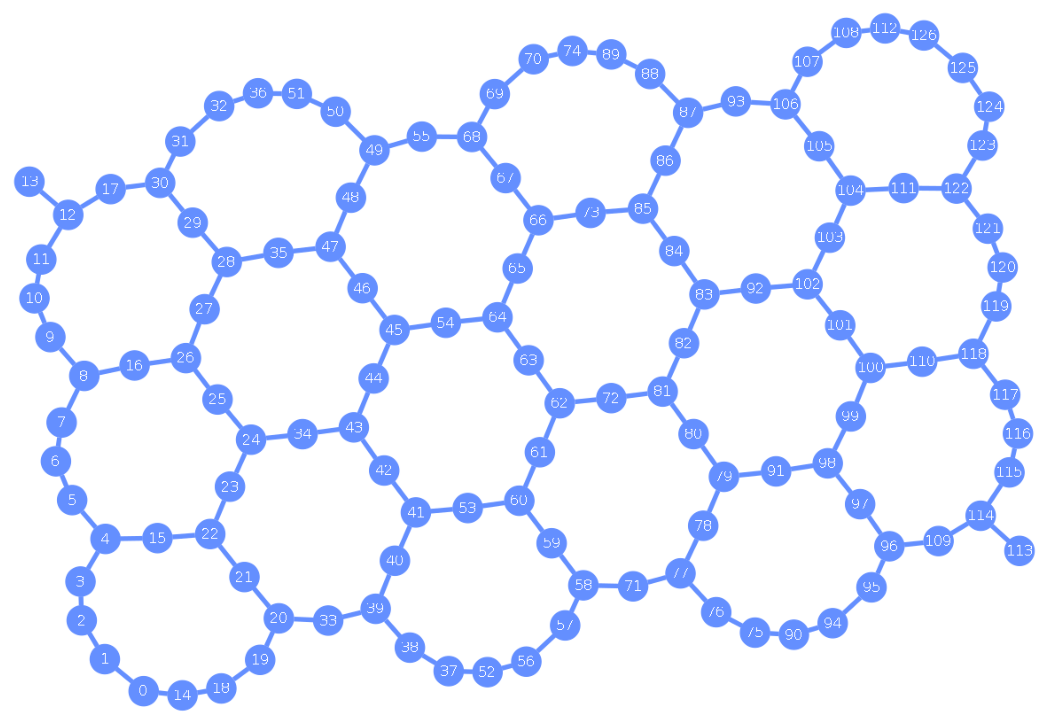

In [22]:
plot_coupling_map(B.num_qubits, None, cmapB.get_edges())

# Task 2 #

In [33]:
from qiskit import QuantumCircuit

# One‑bit QRNG
# qc1 = QuantumCircuit(1)
# qc1.h(0)          # coin‑flip on qubit 0
# qc1.measure_all() # record the outcome as a classical bit
# qc1.draw()

# k‑bit QRNG
def qrng(k: int):
    qc = QuantumCircuit(k)
    for q in range(k):
        qc.h(q)          # one coin‑flip per qubit
    qc.measure_all()
    return qc

k = 3
qc = qrng(k)
# print (qc)
qc.draw()

┌───┐ ░ ┌─┐      
   q_0: ┤ H ├─░─┤M├──────
        ├───┤ ░ └╥┘┌─┐   
   q_1: ┤ H ├─░──╫─┤M├───
        ├───┤ ░  ║ └╥┘┌─┐
   q_2: ┤ H ├─░──╫──╫─┤M├
        └───┘ ░  ║  ║ └╥┘
meas: 3/═════════╩══╩══╩═
                 0  1  2

**Review**. We designed a 3-Qubit Random Number Generator circuit using only **single-qubit Hadamard gates**, and single qubit measurements in the computational basis $\{\ket{0}, \ket{1}\}$. This circuit is comprised of 3 stages:

1. **Qubit State Preparation**: Each of the three qubits (labelled $q_0$, $q_1$, and $q_2$) are initialised to the basis state $\ket{0}$. 
2. **Uniform Randomization**: We individually transform each qubit ($q_i$) to the equal superposition state $\ket{q_i} = \frac{1}{\sqrt{2}}\left(\ket{0} + \ket{1} \right)$ for $i = \{0, 1, 2\}$. This primes the measurement outcome for each qubit state $\{\ket 0$, $\ket 1\}$ to have equal probablility ($50\%)$.
3. **Measurement**: Each qubit is measured in the computational basis individually, and we report a 3-bit string of $\{0, 1\}$ corresponding to each measurment outcome of $\{\ket{0}, \ket{1}\}$ respectively.

# Task 3 #

In [122]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

pmA = generate_preset_pass_manager(optimization_level=3, backend=A)
isaA = pmA.run(qc)

pmB = generate_preset_pass_manager(optimization_level=3, backend=B)
isaB = pmB.run(qc)

print("A ops:", isaA.count_ops(), "depth:", isaA.depth())
print("B ops:", isaB.count_ops(), "depth:", isaB.depth())

# (Optional) See which physical qubits were chosen for your logical qubits 0..k-1
print("ISA A initial_index_layout:", isaA.layout.initial_index_layout())
print("ISA A routing_permutation: ", isaA.layout.routing_permutation())
print("ISA A final_index_layout:  ", isaA.layout.final_index_layout())

print("ISA B initial_index_layout", isaB.layout.initial_index_layout())
print("ISA B routing_permutation", isaB.layout.routing_permutation())
print("ISA B final_index_layout:  ", isaB.layout.final_index_layout())

# (Optional) Peek at the device’s native gate names (you don't need to know them yet)
print("A basis gates:", A.configuration().basis_gates)
print("B basis gates:", B.configuration().basis_gates)
# Draw the transpiled circuit
isaA.draw()

A ops: OrderedDict([('rz', 6), ('sx', 3), ('measure', 3), ('barrier', 1)]) depth: 4
B ops: OrderedDict([('rz', 6), ('sx', 3), ('measure', 3), ('barrier', 1)]) depth: 4
ISA A initial_index_layout: [37, 66, 55, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132]
ISA A routing_permutation:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 5

global phase: 3π/4
          ┌─────────┐┌────┐┌─────────┐ ░ ┌─┐      
q_0 -> 37 ┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├─░─┤M├──────
          ├─────────┤├────┤├─────────┤ ░ └╥┘   ┌─┐
q_2 -> 55 ┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├─░──╫────┤M├
          ├─────────┤├────┤├─────────┤ ░  ║ ┌─┐└╥┘
q_1 -> 66 ┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├─░──╫─┤M├─╫─
          └─────────┘└────┘└─────────┘ ░  ║ └╥┘ ║ 
  meas: 3/════════════════════════════════╩══╩══╩═
                                          0  1  2

**Review**. We address how the transpiler assigns qubits for a quantum circuit, for two different quantum computers.

1. The instruction counts and gates used for both quantum computers are identical, since the implementation of this circuit requires only **rz** and **sx** gates which both quantum computers use. 

2. No, there are no 2-qubit operations in the implementation of this circuit in either quantum computer. This concurs with the theoretical circuit design.

3. The transpiler assigned our logical qubits to physical qubits as $q_{0} \rightarrow 37, q_{1} \rightarrow 66, q_{2} \rightarrow 125$. The physical qubits are distant from one another ($\geq 10$ qubits in between each pair). 

    3.1 ```isaA.layout.initial_index_layout()``` consists of all the qubits assigned for implementation of the circuit.
    
    3.2 ```isaA.layout.routing_permutation()``` is a mapping which indicates the order in which qubit operations are conducted, including **SWAP** operations. This happens when the circuit contains multi-qubit operations, and the assigned qubits are distant from one another. In our case, the array returned is the trivial version (```[0,1,2,...]```) since our circuit has no multi-qubit gates. 

    3.3 ```isaA.layout.final_index_layout()``` consists of the final positions of the qubits in the order of operations (including **SWAP** operations) assigned for the implementation of the circuit. Additionally, this does not include unassigned qubits, as in the previous two arrays.

In [91]:
from qiskit_ibm_runtime import SamplerV2 as Sampler

# Hardware: target a specific backend (backend B)
sampler = Sampler(mode=B) # or mode=B
resultB = sampler.run([isaB], shots=4000).result()
countsB = resultB[0].data.meas.get_counts() # {'010011': n, ...}
total = sum(countsB.values())
probs = {bitstr: count / total for bitstr, count in countsB.items()}
print (probs)

{'111': 0.122, '001': 0.12425, '000': 0.12275, '110': 0.12925, '101': 0.12725, '010': 0.12675, '100': 0.1295, '011': 0.11825}


In [111]:
# Simulator with the same result schema (backend B)
from qiskit.primitives import BackendSamplerV2
from qiskit_aer import AerSimulator

sim_resultB = BackendSamplerV2(backend=AerSimulator()).run([isaB], shots=4000).result()
sim_countsB = sim_resultB[0].data.meas.get_counts()

# Task 4 #

In [112]:
# Sampled counts from simulator A
sim_resultA = BackendSamplerV2(backend=AerSimulator()).run([isaA], shots=4000).result()
sim_countsB = sim_resultB[0].data.meas.get_counts()
sim_countsA = sim_resultA[0].data.meas.get_counts()

In [ ]:
# Sampled counts from backend A
resultA = Sampler(mode=A).run([isaA], shots=4000).result()
countsA = resultA[0].data.meas.get_counts()

In [114]:
# Sampled counts from backend B and simulations based on backend B are already calculated in Task 3! no need to run the computation for a second time.
resultA = resultB
countsA = countsB

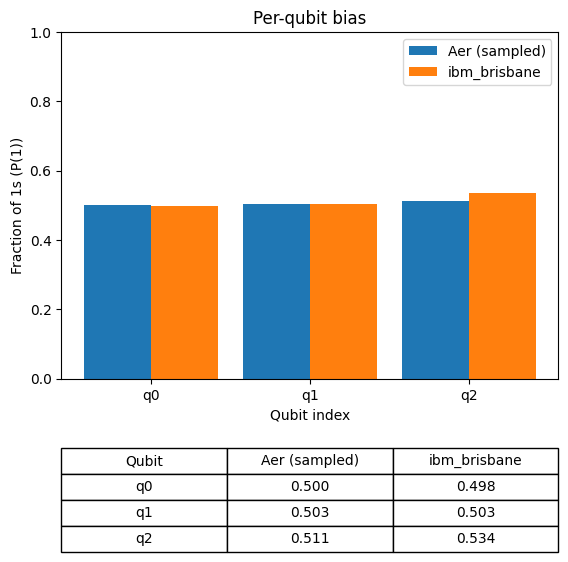

In [51]:
import numpy as np, matplotlib.pyplot as plt

def per_qubit_p1(counts, n):
    shots = sum(counts.values())
    p = np.zeros(n, dtype=float)
    for s, c in counts.items():                 # s like '0101' (qubit 0 is rightmost)
        for j, ch in enumerate(reversed(s)):    # map column 0 -> qubit 0
            if ch == '1':
                p[j] += c
    return p / max(shots, 1)

k = qc.num_qubits  # or isaA.num_qubits
p_sim = per_qubit_p1(sim_counts, k)
p_B   = per_qubit_p1(countsB,    k)

x = np.arange(k); w = 0.42
fig, ax = plt.subplots()
# Plot the bars
ax.bar(x - w/2, p_sim, width=w, label="Aer (sampled)")
ax.bar(x + w/2, p_B,   width=w, label=B.name)

ax.set_xlabel("Qubit index")
ax.set_ylabel("Fraction of 1s (P(1))")
ax.set_title("Per-qubit bias")
ax.set_xticks(x, [f"q{j}" for j in range(k)])
ax.set_ylim(0, 1)
ax.legend()
plt.tight_layout()

# Table data
columns = ["Qubit", "Aer (sampled)", B.name]
cell_text = [[f"q{j}", f"{p_sim[j]:.3f}", f"{p_B[j]:.3f}"] for j in range(k)]

# Add table below the plot
table = plt.table(
    cellText=cell_text,
    colLabels=columns,
    loc="bottom",
    cellLoc="center",
    bbox=[0, -0.5, 1, 0.3]
)

# Adjust layout so table fits under plot
plt.subplots_adjust(left=0.2, bottom=0.2)

plt.show()


# Bonus Tasks #

## B.1 Monobit bias (per qubit and overall) ##

In [ ]:
import numpy as np

# defining an array to make printing easier in this Bonus section
name_list = np.array([countsA, sim_countsA, countsB, sim_countsB])
result_list = np.array([resultA, sim_resultA, resultB, sim_resultB])
print_list = np.array(["Backend A", "Simulation of Backend A", "Backend B", "Simulation of Backend B"])

def monobit_summary(counts, res, k):
    shots = sum(counts.values())
    bitstrings = res[0].data.meas.get_bitstrings()
    M = np.array([[int(b) for b in s[::-1]] for s in bitstrings], dtype=int) # measurement data
    p = M.mean(axis=0)                 # per-qubit fraction of 1s
    overall = float(p.mean())
    se = np.sqrt(0.25/shots)           # rough expected fluctuation for a fair coin
    suspect = np.abs(p - 0.5) > 3*se   # rule-of-thumb: outside ±3·SE
    return p, overall, se, suspect

for name, res_name, print_name in zip (name_list, result_list, print_list):
    p, overall, se, flag = monobit_summary(name, res_name, k)
    print (print_name, "per-qubit P(1):", np.round(p, 3), "overall:", round(overall, 3), "SED~", round(se, 4))
    print (print_name, "suspect qubits:", np.where(flag)[0].tolist(), "\n")


Backend A per-qubit P(1): [0.492 0.496 0.508] overall: 0.499 SED~ 0.0079
Backend A suspect qubits: [] 

Simulation of Backend A per-qubit P(1): [0.516 0.492 0.504] overall: 0.504 SED~ 0.0079
Simulation of Backend A suspect qubits: [] 

Backend B per-qubit P(1): [0.492 0.496 0.508] overall: 0.499 SED~ 0.0079
Backend B suspect qubits: [] 

Simulation of Backend B per-qubit P(1): [0.498 0.492 0.52 ] overall: 0.503 SED~ 0.0079
Simulation of Backend B suspect qubits: [] 



## B.2 Runs test (temporal alternation) ##

In [117]:
def runs_fraction_per_qubit(counts, res, k):
    bitstrings = res[0].data.meas.get_bitstrings()
    M = np.array([[int(b) for b in s[::-1]] for s in bitstrings], dtype=int)
    flips = (M[1:] != M[:-1]).mean(axis=0)   # fraction of shot-to-shot flips per qubit
    return flips

for name, res_name, print_name in zip (name_list, result_list, print_list):
    flips = runs_fraction_per_qubit(name, res_name, k)
    print (print_name, "runs (flip fraction) per qubit:", np.round(flips, 3), "\n")

Backend A runs (flip fraction) per qubit: [0.497 0.517 0.499] 

Simulation of Backend A runs (flip fraction) per qubit: [0.484 0.502 0.504] 

Backend B runs (flip fraction) per qubit: [0.497 0.517 0.499] 

Simulation of Backend B runs (flip fraction) per qubit: [0.49  0.523 0.509] 



## B.3 Lag‑1 autocorrelation (temporal dependence) ##

In [119]:
def autocorr_lag1(counts, res, k):
    bitstrings = res[0].data.meas.get_bitstrings()
    M = np.array([[int(b) for b in s[::-1]] for s in bitstrings], dtype=int)
    X = M - M.mean(axis=0, keepdims=True)
    num = (X[1:]*X[:-1]).sum(axis=0)
    den = (X[:-1]**2).sum(axis=0)
    ac1 = np.divide(num, den, out=np.zeros_like(num, dtype=float), where=den>0)
    return ac1

for name, res_name, print_name in zip (name_list, result_list, print_list):
    ac1 = autocorr_lag1(name, res_name, k)
    print (print_name, "lag-1 autocorr per qubit:", np.round(ac1, 3), "\n")

Backend A lag-1 autocorr per qubit: [ 0.006 -0.033  0.002] 

Simulation of Backend A lag-1 autocorr per qubit: [ 0.03  -0.004 -0.008] 

Backend B lag-1 autocorr per qubit: [ 0.006 -0.033  0.002] 

Simulation of Backend B lag-1 autocorr per qubit: [ 0.02  -0.047 -0.02 ] 



## B.4 Inter‑qubit correlation (spatial dependence) ##

In [121]:
import itertools

def interqubit_corr(counts, res, k):
    bitstrings = res[0].data.meas.get_bitstrings()
    M = np.array([[int(b) for b in s[::-1]] for s in bitstrings], dtype=int)
    X = M - M.mean(axis=0, keepdims=True)
    cov = (X.T @ X) / (len(M)-1)
    std = X.std(axis=0, ddof=1)
    R = cov / (std[:,None]*std[None,:])
    np.fill_diagonal(R, 1.0)
    return R

for name, res_name, print_name in zip (name_list, result_list, print_list):
    R = interqubit_corr(name, res_name, k)
    flags = [(i,j,float(R[i,j])) for i,j in itertools.combinations(range(k),2) if abs(R[i,j])>0.1]
    print (print_name, "suspicious pairs:", flags[:10])

Backend A suspicious pairs: []
Simulation of Backend A suspicious pairs: []
Backend B suspicious pairs: []
Simulation of Backend B suspicious pairs: []


## B.5 Interpretation ##

- how well computers do compared to simulation
- which computer does best
- for task 4 if any suspicious pairs say how they relate to neighbouring pairs in task 1

# Generative AI Disclosure #

We used ChatGPT-5 and ChatGPT-4 for AI assistance during this assignment. A breakdown of the usage per task is shown below:

0. Setup: Initially we used ChatGPT to help us with the keywords to initialize and clone a public GitHub repository for version control and collaboration. The conversation can be found in full [here](https://chatgpt.com/share/68b8431f-2a18-8009-8724-6297788986b4). We validated this by pushing changes and seeing that the repository was initialized and behaving as expected.

1. Task 1: We used ChatGPT to create a hidden .env folder where we could store our API key locally and read it into a given variable without leaking it on GitHub. The conversation is found [here](https://chatgpt.com/share/68b843a0-0868-8009-bd1e-75e56f4deff3). We validated this by consulting package documentation.

2. Task 2: We did not use any AI tools.

3. Task 3: We did not use any AI tools.

4. Task 4: We used ChatGPT to help us with syntax for creating a table with the empirical fraction of 1s per qubit. The conversation is found [here](https://chatgpt.com/share/68b84546-5848-8009-b5ca-56f8d9ceefa1). We validated the code by comparing the values in the table to the values in each array and improved the aesthetics of the plot by manually adjusting the location of the table.

5. Bonus: We used ChatGPT to understand the syntax of the bitstring slicing. Specifically, to understand that the two semicolons were reversing each bit in the bitstring. The conversation is found [here](https://chatgpt.com/share/68b84147-dc98-8009-a1fd-51d081cba773).